# 未学習のエネルギーの深度線量分布に対する、角度の推論

一番結果が良かった場合について、未学習のエネルギーの電子を照射した場合の線量分布から角度が推論できるか検証する

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


# Allocation GPU hardware ID = 0
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.set_visible_devices(physical_devices[1], 'GPU')

2022-11-24 13:49:10.036415: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


2022-11-24 13:49:11.824587: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-24 13:49:11.825503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-24 13:49:11.854775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:84:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-24 13:49:11.855028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-24 13:49:11.855410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:03:0

In [2]:
model = tf.keras.models.load_model("model_03")
model.summary()

2022-11-24 13:49:11.969598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:49:11.973784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-24 13:49:11.973835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-24 13:49:11.973868: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-24 13:49:11.973895: I tensorflow/stream_executor/platform/

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 30, 30, 75, 16)    144       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 75, 16)    64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 15, 15, 37, 32)    4128      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 15, 37, 32)    128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 7, 18, 64)      16448     
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 18, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 18, 64)     

In [3]:
dir_name = "data_05" 
theta = 0
file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for phi in range(-45,45)]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

In [4]:
pred = model.predict(data)

2022-11-24 13:49:23.340889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-24 13:49:23.352813: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099975000 Hz
2022-11-24 13:49:23.482262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-24 13:49:23.650744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-24 13:49:24.201369: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-24 13:49:24.228012: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [5]:
pred = pred.reshape(90,19,19)

In [6]:
hist_theta = [pred[i].sum(axis=0) for i in range(90)]
hist_phi   = [pred[i].sum(axis=1) for i in range(90)]

theta = [-45 + 5 * i for i in range(19)]
phi   = [-45 + 5 * i for i in range(19)]

In [7]:
mean_theta = []
mean_phi   = []

for j in range(90):
    mean_t = 0
    mean_p = 0
    for i in range(19):
        mean_t += hist_theta[j][i] * theta[i]
        mean_p += hist_phi[j][i] * theta[i]
    
    mean_theta.append(mean_t)
    mean_phi.append(mean_p)

推論した結果の重みの分布と、加重平均の値を垂直の線で表した。

青が$\theta$でオレンジ色が$\phi$の情報を意味する

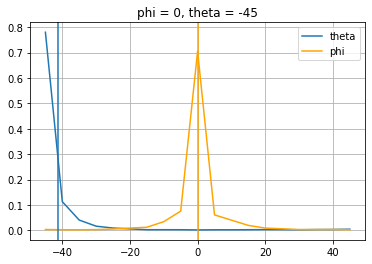

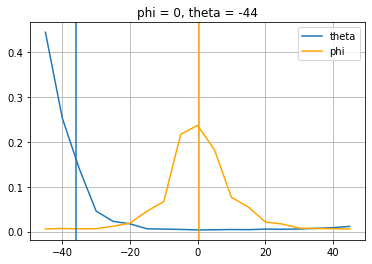

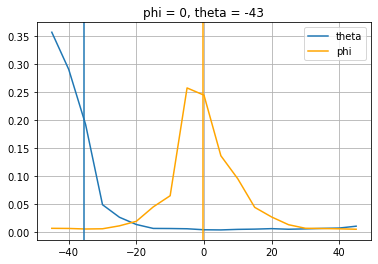

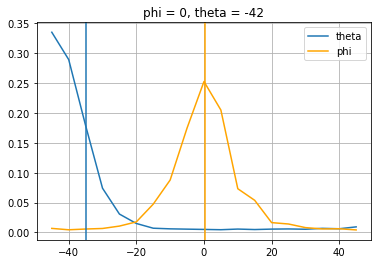

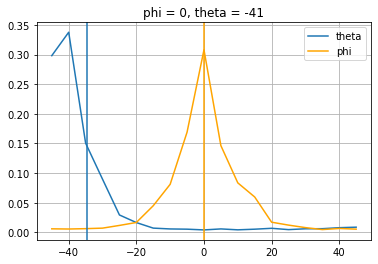

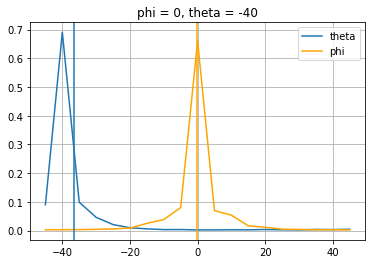

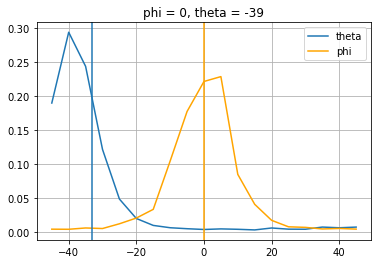

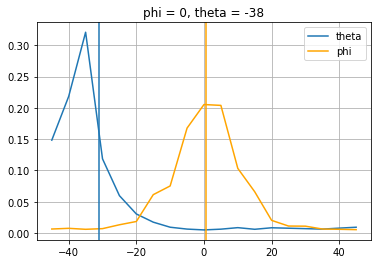

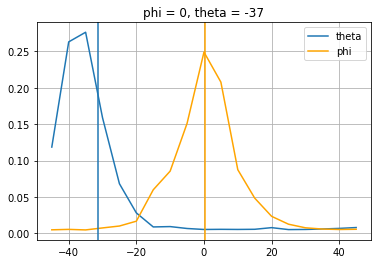

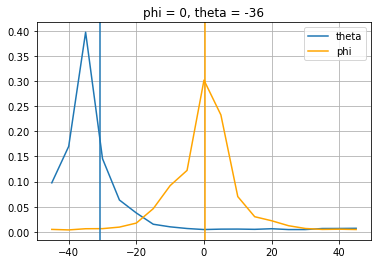

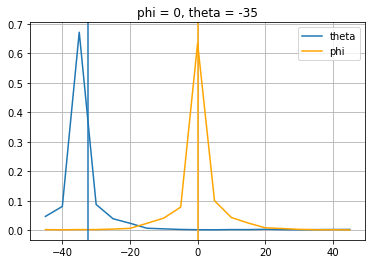

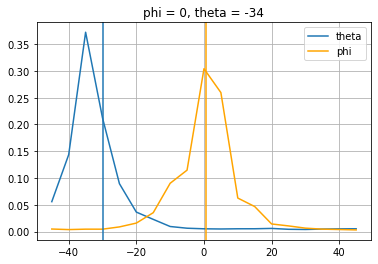

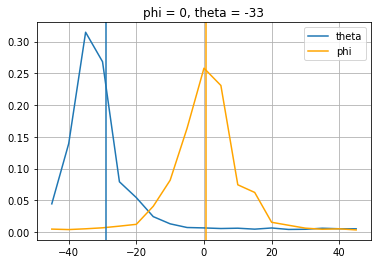

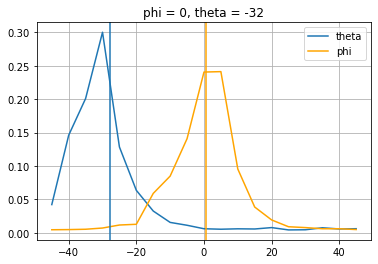

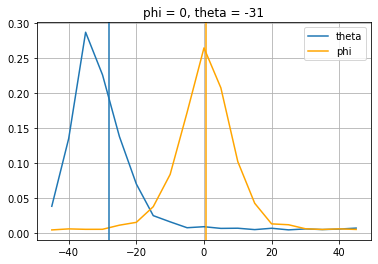

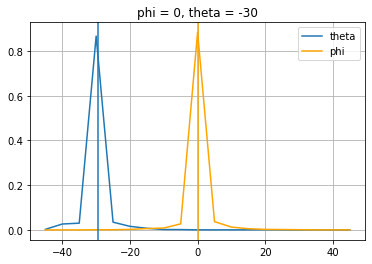

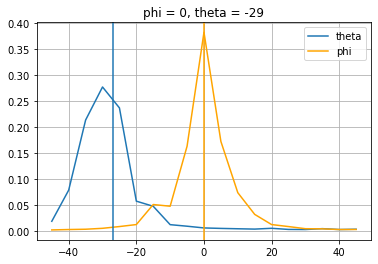

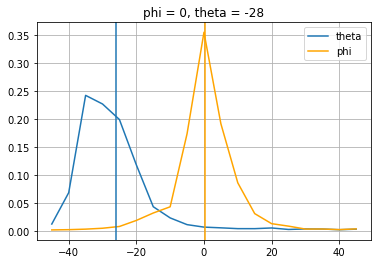

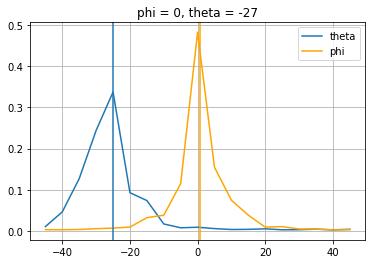

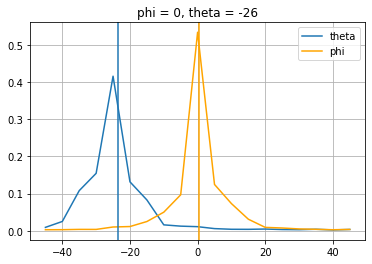

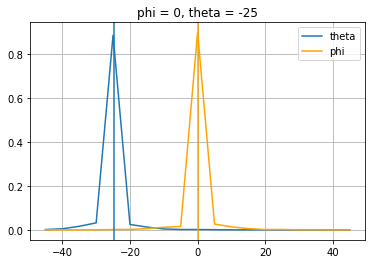

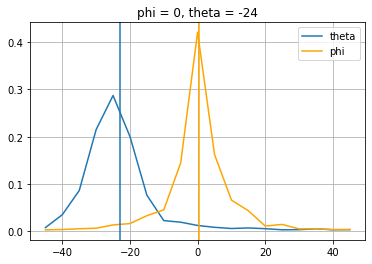

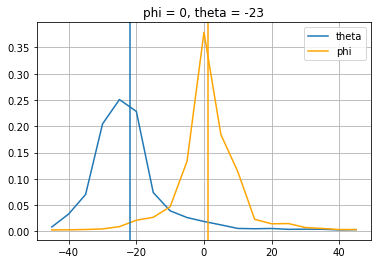

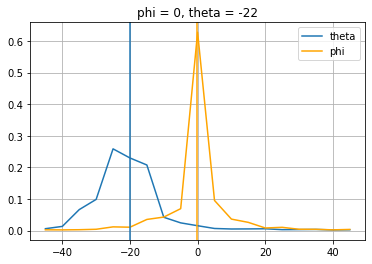

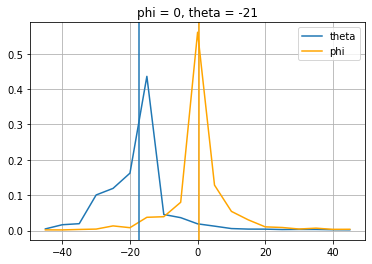

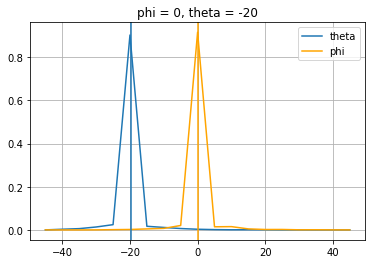

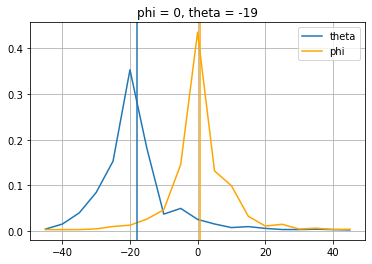

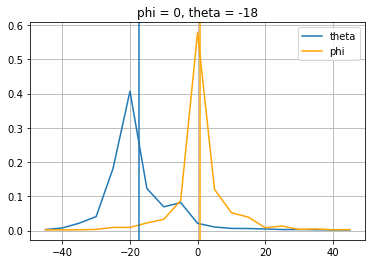

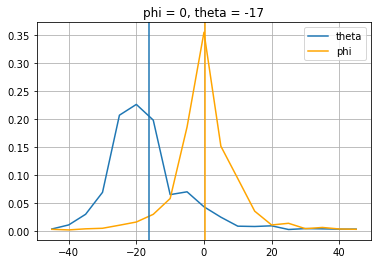

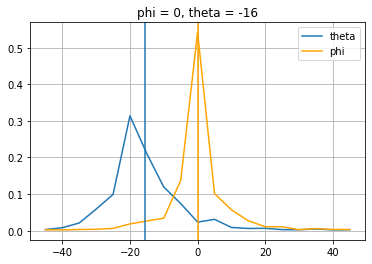

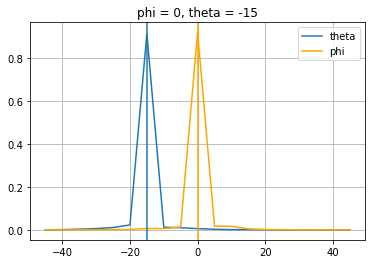

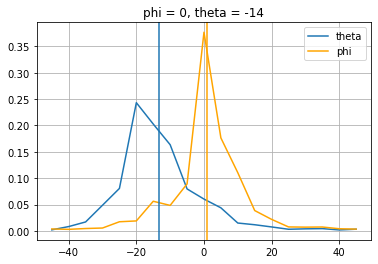

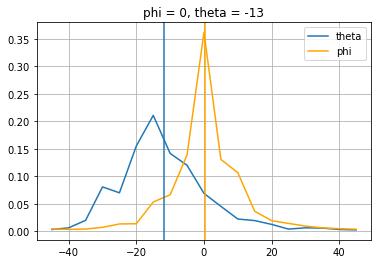

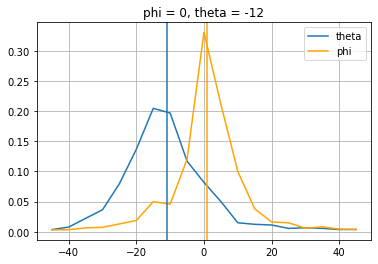

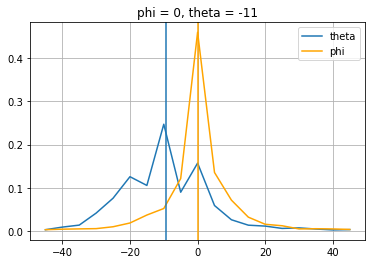

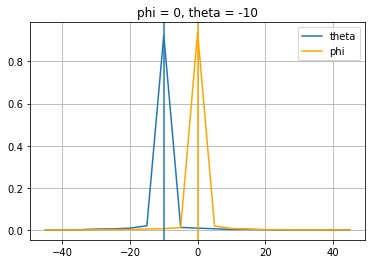

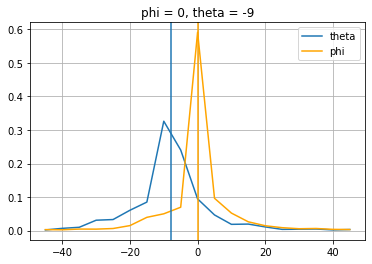

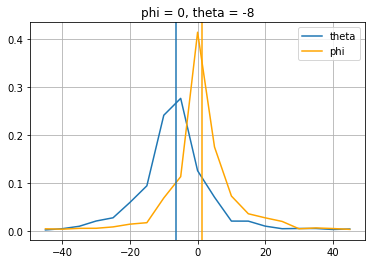

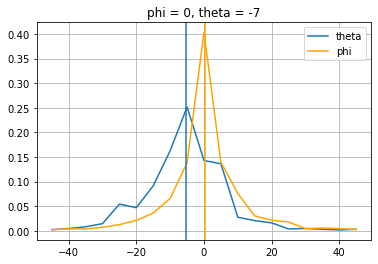

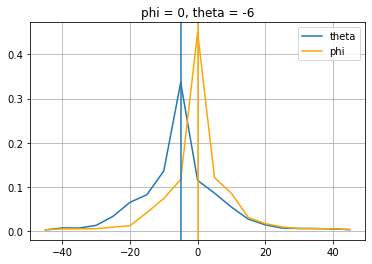

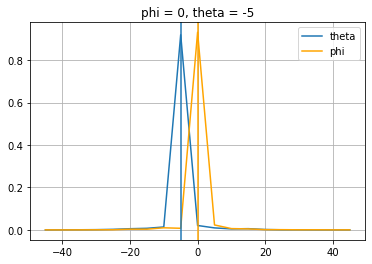

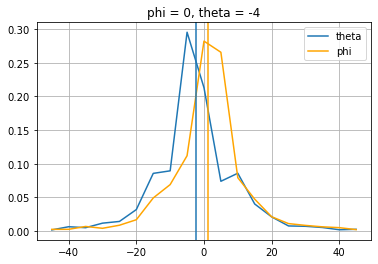

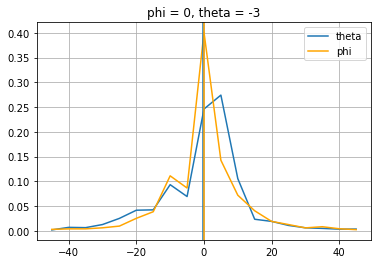

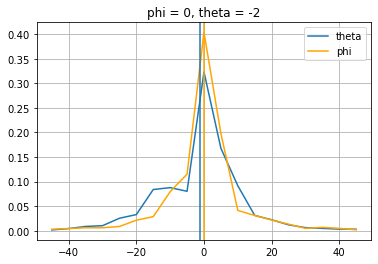

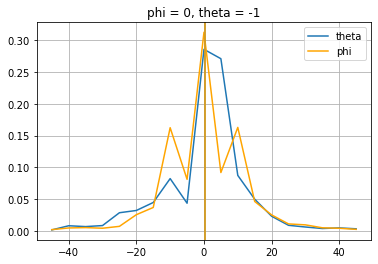

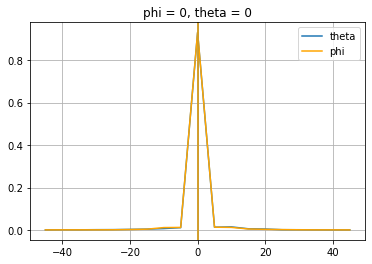

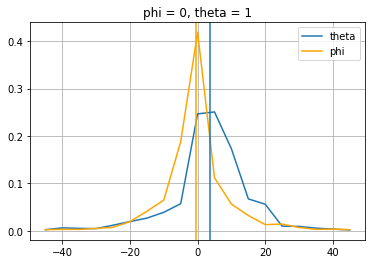

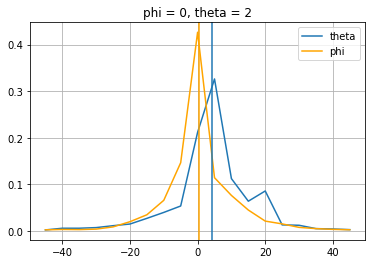

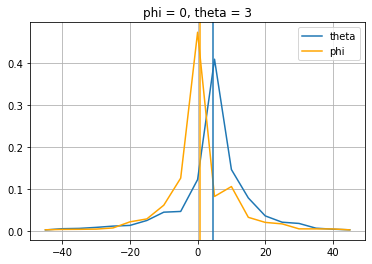

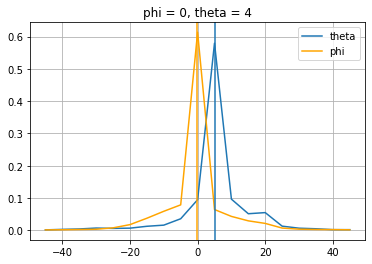

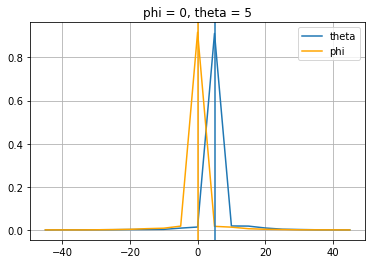

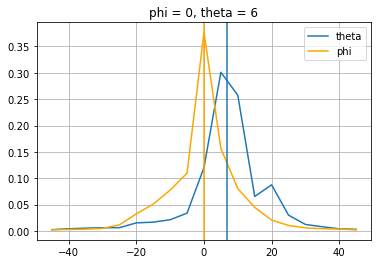

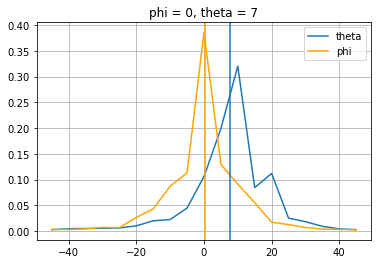

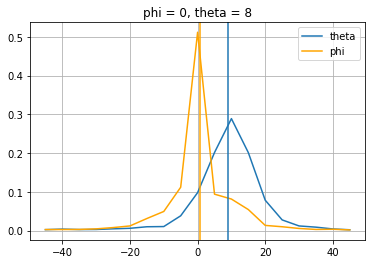

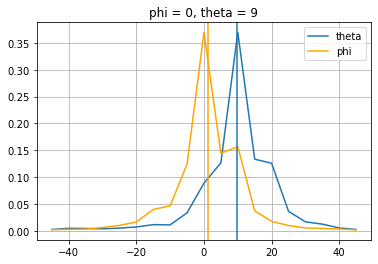

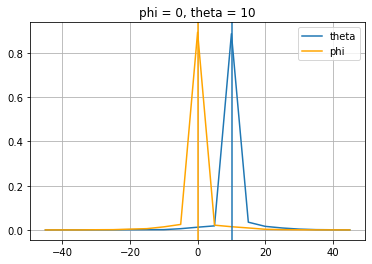

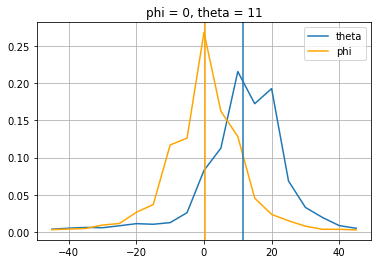

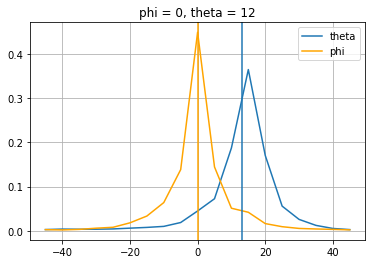

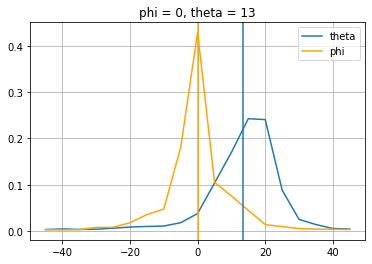

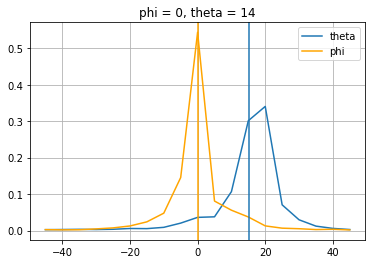

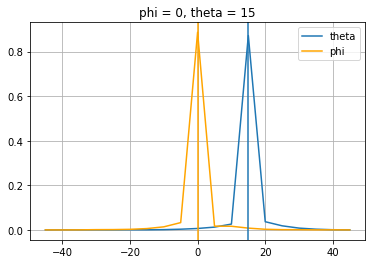

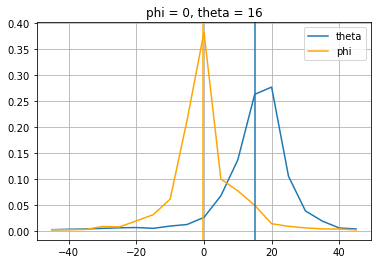

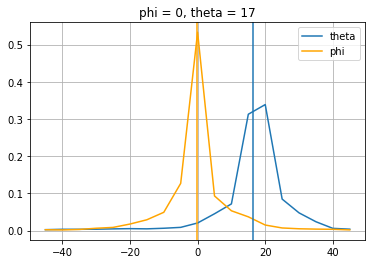

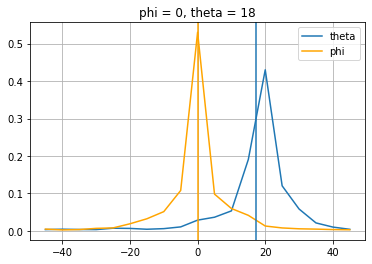

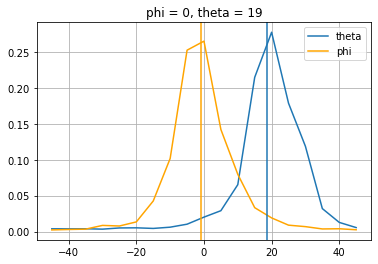

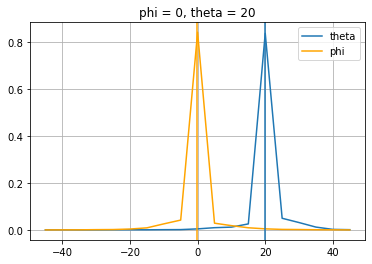

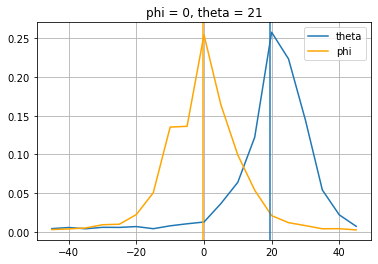

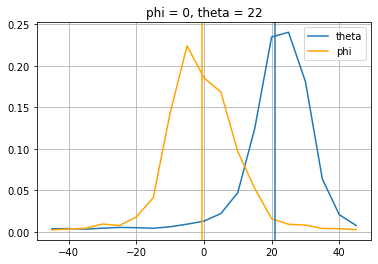

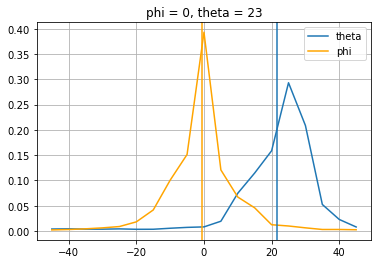

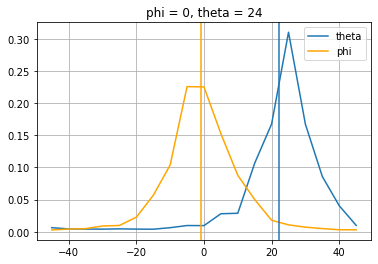

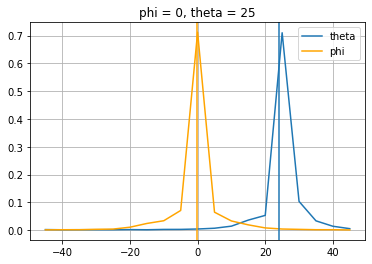

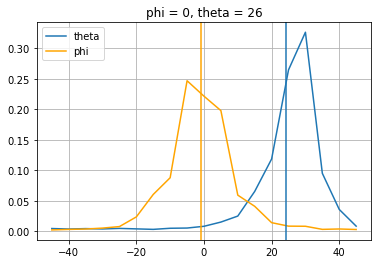

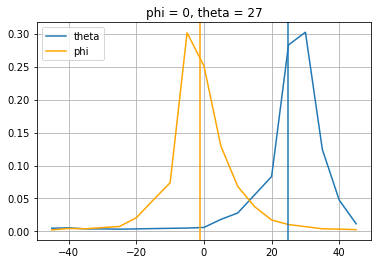

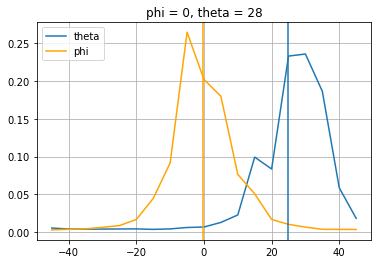

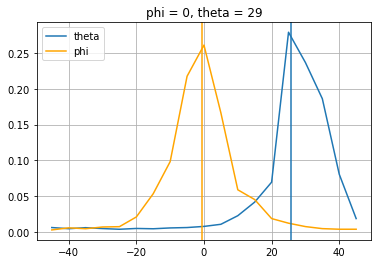

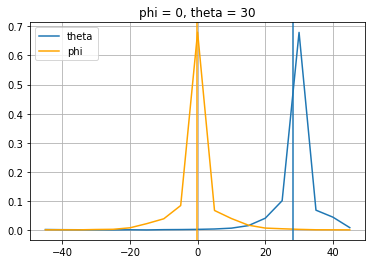

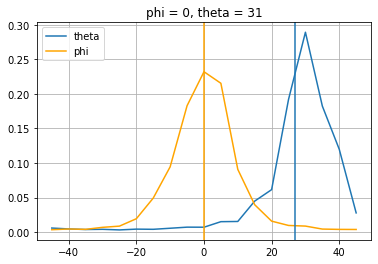

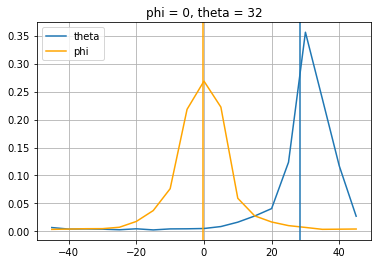

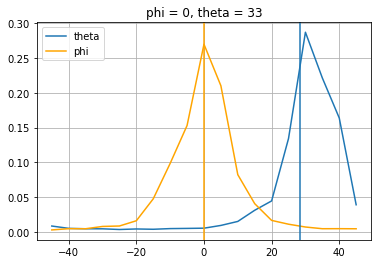

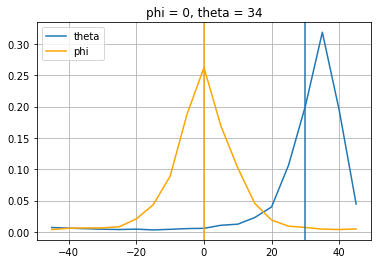

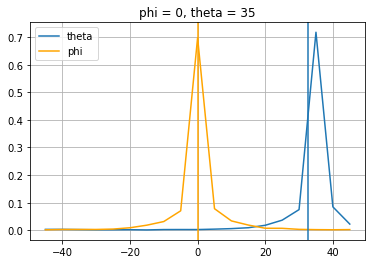

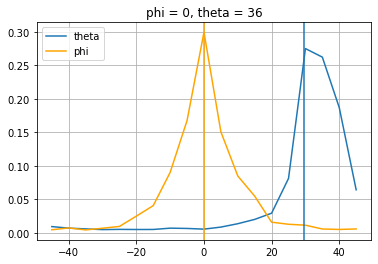

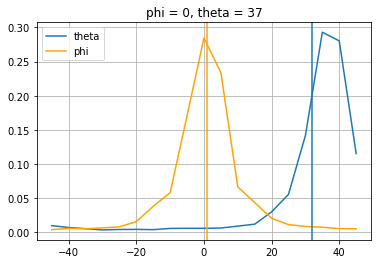

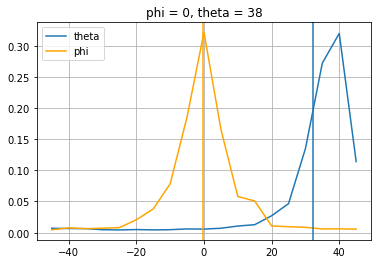

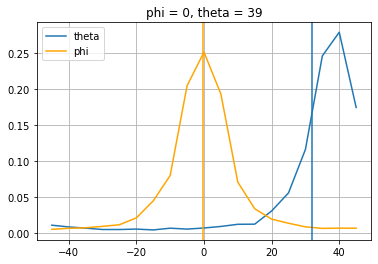

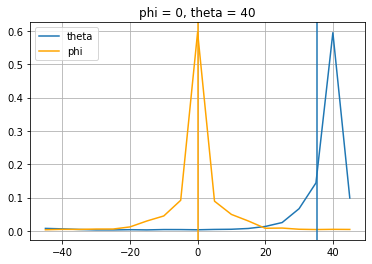

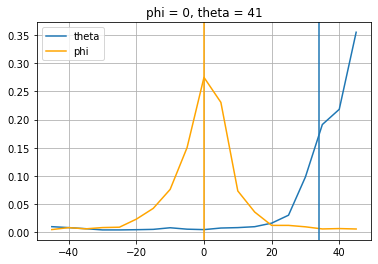

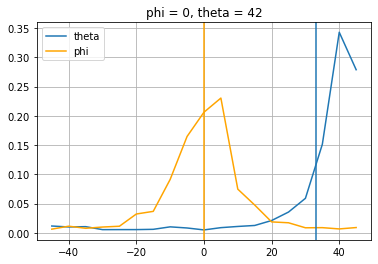

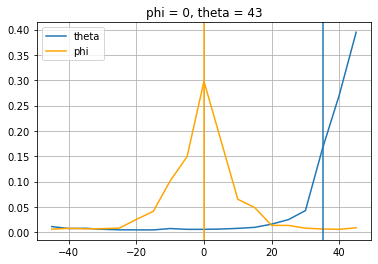

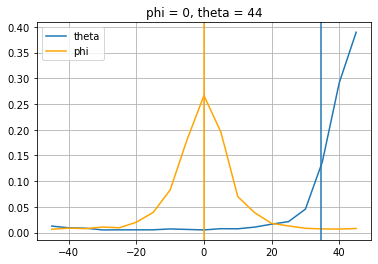

In [18]:
for i in range(90):
    plt.plot(theta,hist_theta[i], label = "theta")
    plt.plot(phi,hist_phi[i], color = "orange", label = "phi")
    plt.axvline(mean_theta[i])
    plt.axvline(mean_phi[i],color = "orange")
    plt.grid()
    plt.title("phi = 0, theta = "+str(i-45))
    plt.legend()
    plt.show()
    plt.close()

絵だけで見ても精度についてはわからない。正解と加重平均の差を求めた。

縦軸は度、横軸はthetaの入射角度

In [9]:
theta_solved = [-45 + i for i in range(90)]

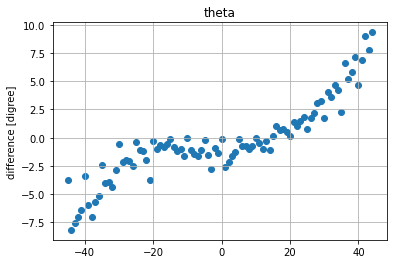

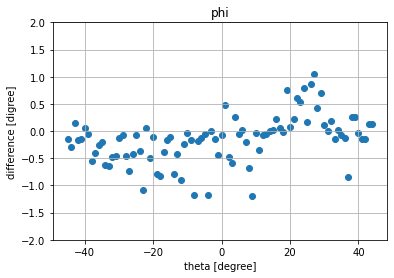

In [11]:
diff = [theta_solved[i] - mean_theta[i] for i in range(90)]
plt.title("theta")
plt.scatter(theta_solved, diff)
plt.ylabel("difference [digree]")
plt.grid()
plt.show()
plt.close()

diff_phi = [0 - mean_phi[i] for i in range(90)]
plt.scatter(theta_solved, diff_phi)
plt.grid()
plt.title("phi")
plt.ylabel("difference [digree]")
plt.xlabel("theta [degree]")
plt.ylim(-2,2)
plt.show()
plt.close()

これを見ると、角度が急になっている時に精度が落ちている事が確認できる。これは、分布が正規分布ではなくなっている事が原因。

ピークで求めると、最大で2.5の誤差の範囲を許容する必要がある。それでいいのか。これを改善するためには、推論したい粒度（今回なら1度単位）でネットワークを作成しないといけない。

outのサイズを91 * 91のone-hotにする。現状のネットワークのサイズで表現力が足りるか？

出力を二つにし、粒度1度ずつの出力にするほうが複雑さを回避できる
